In [28]:
import numpy as np
import healpy as hp
from matplotlib import pyplot as plt

from simulate_planck_maps import simulate_planck_maps
from compute_cl import compute_cl
from cosine_smoothed_mask import cosine_smoothed_mask
from compute_weights import compute_weights
from compute_alm_ilc import compute_alm_ilc
from compute_decoupled_cl import compute_decoupled_cl
from compute_decoupled_cl_2 import compute_decoupled_cl_2
from mask_maps import mask_maps

%matplotlib inline

Definitions

In [29]:
nside=128
npix=hp.nside2npix(nside=nside)
freqs = np.array([28.4,  44.1,  70.4,  100.0,  143.0,  217.0,  353.0])
n_freqs = len(freqs)

Simulate maps using PySM

In [30]:
noise, dust, sync, ff, cmb = simulate_planck_maps(nside, freqs)

Combining the CMB and foreground maps to be input into ILC

In [31]:
maps_pl = cmb + noise + dust + sync + ff #cmb and foregrounds combined


Transforimng frequency maps to harmonic space by decomposition

In [32]:
#transform maps to spherical harmonics
lmax=3*nside -1 #default is lmax= 3*nside+1
alm_size=hp.Alm.getsize(lmax)
alm_maps=np.zeros((n_freqs, alm_size), dtype=complex) #storing coefficients in an array of dim n_freqs*almsize. dtype is complex to account for -ive values

for nf in range(n_freqs):
    alm_maps[nf,:]= hp.map2alm(maps_pl[nf,:], lmax=lmax, mmax=None, iter=0, pol=False) #record alm corresponding to each f for a corresponding l and m
   

Computing the angular power spectrum for the unmasked data

In [33]:
alm_p, C_l=compute_cl(alm_maps, lmax, n_freqs)
print(alm_p.shape)
print(C_l.shape)

(7, 384)
(384, 7, 7)


Using a cosine smoothed mask to make sure the smoothing accurately masks the emission on the galactic plane. It can be done using cosine smoothing.
Where we put the mask as:
 $$mask= \frac{1}{2} \Big( 1- \cos(\pi \frac{|b|-b_{min}}{b_{max}-b_{min}})\Big)$$

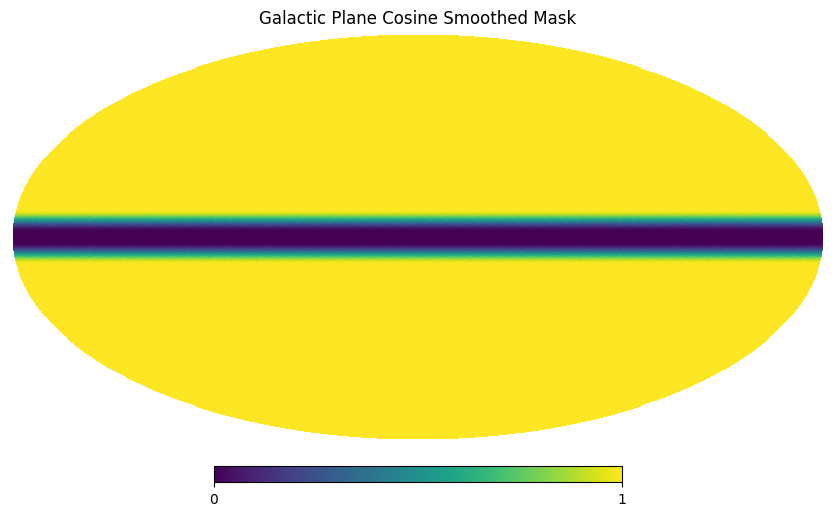

In [34]:
# Generate and plot the mask
mask2 = cosine_smoothed_mask(nside)
mask2= (mask2*(-1))+1
hp.mollview(1-mask2, title="Galactic Plane Cosine Smoothed Mask")

plt.show()

Decoupled power spectra $\hat{C_l^{ij}} = M_{ll'}^{-1} \tilde{C}_l^{ij}$

where $\tilde{C}_l^{ij}$ is the pseudo power spectrum aka the masked power spectrum

In [35]:
pcl, mcm, cl_dec=compute_decoupled_cl(maps_pl, mask2, nside, lmax, n_freqs)
print(mcm.shape)
print(cl_dec.shape)

(384, 384)
(384, 7, 7)


Now we can compute the inverse covariance matrix and compute the weights using $$\omega_i(l) = \frac{\sum_j (C_l^{-1})_{ij} b_{j}}{\sum_{ij}b_i (C_l^{-1})_{ij} b_{j}}$$

where $b_i $ represents the CMB transfer function. $b_i = [1,...,1]$

In [36]:
cl_inv, weights = compute_weights(n_freqs, lmax, cl_dec)
print(cl_inv.shape)
print(weights.shape) #nf x m array

(7, 7)
(7, 384)


Visualizing the weights

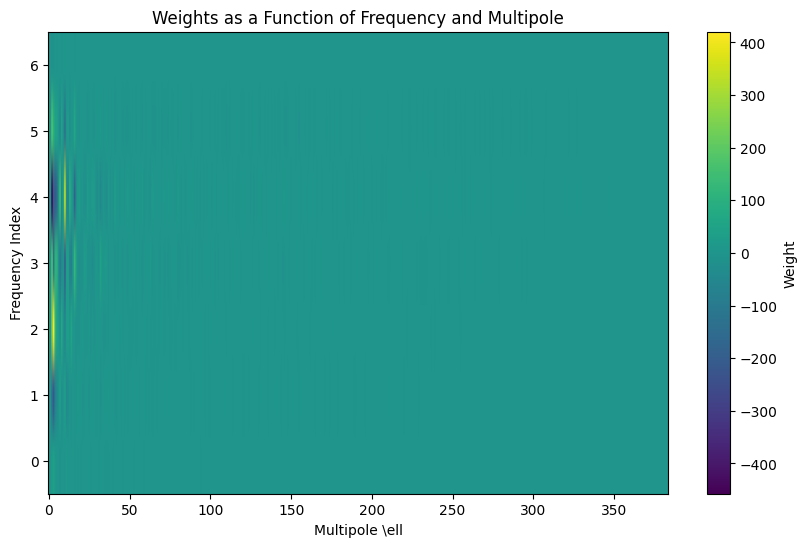

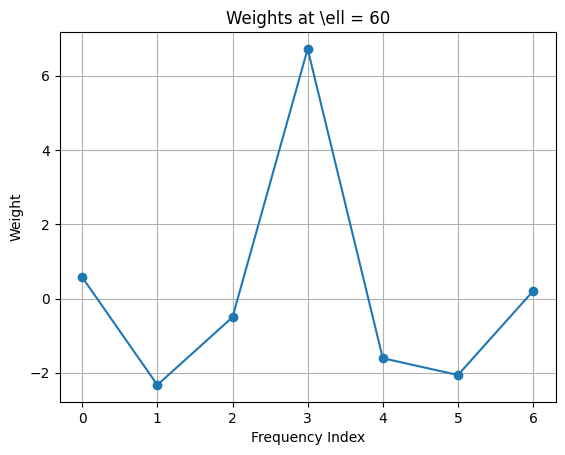

In [37]:
plt.figure(figsize=(10, 6))
plt.imshow(weights[:,:], aspect='auto', cmap='viridis', origin='lower')
plt.colorbar(label="Weight")
plt.xlabel("Multipole \\ell")
plt.ylabel("Frequency Index")
#plt.xlim(50,)
plt.title("Weights as a Function of Frequency and Multipole")
plt.show()


plt.plot(range(n_freqs), weights[:, 60], marker='o', linestyle='-')

plt.xlabel("Frequency Index")
plt.ylabel("Weight")
plt.title(f"Weights at \\ell = {60}")
plt.grid()

Masking the data and converting the masked maps to harmonic space

In [38]:
maps_masked, alm_masked= mask_maps(maps_pl, mask2, alm_size,lmax, n_freqs, npix)
print(maps_masked.shape)

(7, 196608)


Applying the weights to the masked data

$$a^{ILC}_{lm} = \sum_i w_i(l)a^i_{lm}$$

In [39]:
alm_ilc=compute_alm_ilc(alm_masked, alm_size, weights, lmax)
print(alm_ilc.shape)

(73920,)


Converting back to pixel space

In [40]:
maps_out = hp.alm2map(alm_ilc, nside, lmax=lmax, mmax=None)
print(maps_out.shape)

(196608,)


Computing the angular power spectrum of the masked, component separated map

In [41]:
pcl_hilc, mcm_hilc, cl_hilc=compute_decoupled_cl_2(maps_out, mask2, nside, lmax, n_freqs) 

In [42]:
ells = np.arange(lmax+1)
norm = (ells * (ells + 1)) / (2 * np.pi)

Computing the decoupled power spectrum of the masked CMB map

In [43]:
pcl_cmb, mcm_cmb, cmb_dec= compute_decoupled_cl(cmb, mask2, nside, lmax, n_freqs)

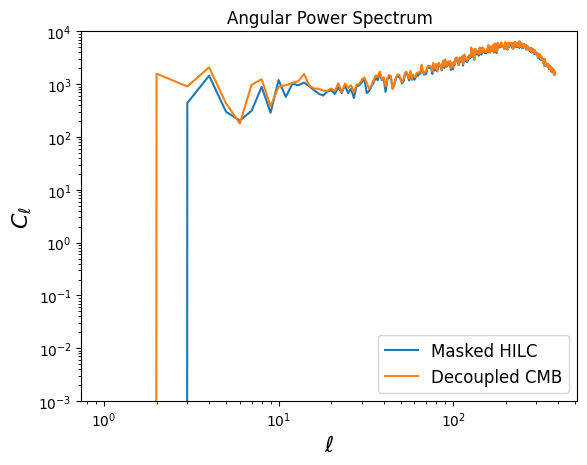

In [44]:
plt.plot(ells, norm*cl_hilc, label='Masked HILC')
plt.plot(ells, norm*cmb_dec[:,0,0], label='Decoupled CMB')

plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.xscale("log")
plt.yscale("log")
plt.ylim(1e-3,1e+4)
plt.legend(fontsize=12)
plt.title("Angular Power Spectrum")
plt.show()

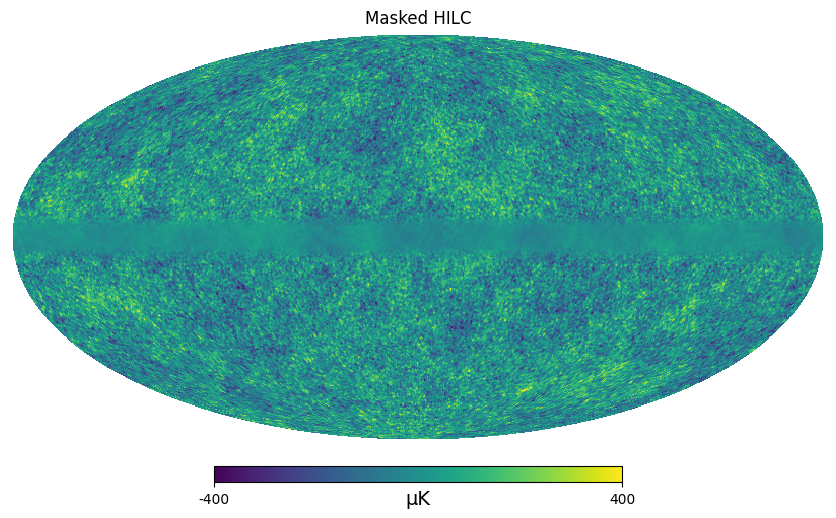

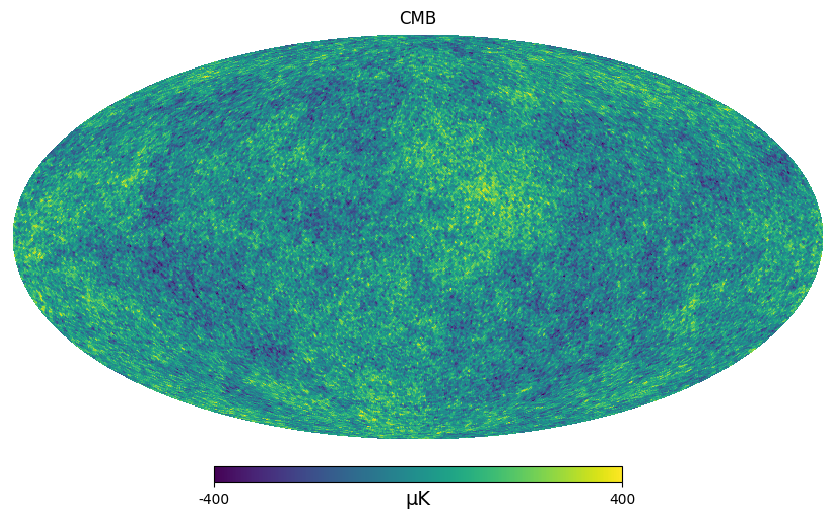

In [45]:
ilc =maps_out-np.mean(maps_out)

hp.mollview(ilc, title= "Masked HILC", min=-400, max=400, unit="μK")
hp.mollview(cmb[0],title ="CMB", min=-400, max=400, unit="μK")


-----------------Extra Plots----------------

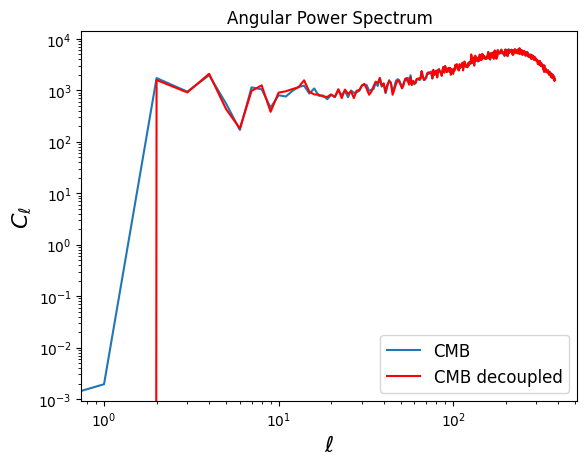

In [46]:
Cl_cmb = hp.anafast(cmb[0]) #input cmb map

plt.plot(ells, norm*Cl_cmb, label='CMB')
plt.plot(ells, norm*cmb_dec[:,0,0], 'r-',label= 'CMB decoupled')
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.xscale("log")
plt.yscale("log")
plt.legend(fontsize=12)
plt.title("Angular Power Spectrum")
plt.show()

Mode Coupling Matrix

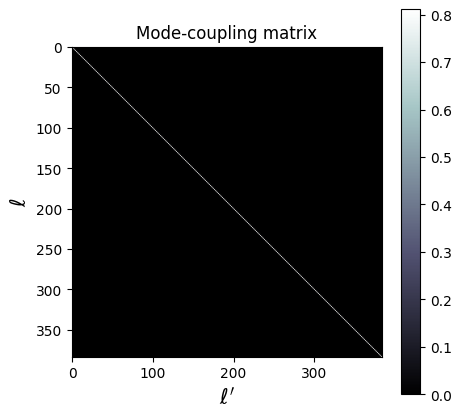

In [47]:
# Plot MCM
plt.figure(figsize=(5, 5))
plt.title('Mode-coupling matrix')
plt.imshow(mcm, cmap='bone')
#plt.plot(mcm[:,30])
plt.ylabel("$\\ell$", fontsize=15)
plt.xlabel("$\\ell'$", fontsize=15)
plt.colorbar()
plt.show()


Compute the fractional difference between the two spectra:

$$
\text{frac\_diff}(\ell) = \frac{C_{\ell}^{\text{Decoupled}} - C_{\ell}^{\text{Input}}}{C_{\ell}^{\text{Input}}}
$$


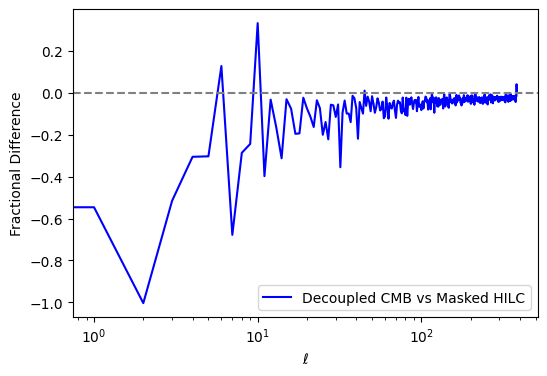

In [48]:
#frac_diff = (cmb_dec[:,0,0] - Cl_cmb) / Cl_cmb  # Avoid division by zero
diff = (cl_hilc - cmb_dec[:,0,0]) / cmb_dec [:,0,0]

plt.figure(figsize=(6, 4))
#plt.plot(ells, frac_diff, label="input CMB vs Decoupled CMB", color="black")
plt.plot(ells, diff, label="Decoupled CMB vs Masked HILC", color="blue")
plt.axhline(0, linestyle="--", color="gray")  # Reference line
#plt.yscale("log")
#plt.ylim(-2500, 500)
plt.xscale("log")
plt.xlabel(r"$\ell$")
plt.ylabel(r"Fractional Difference")
#plt.title("Fractional Difference")
plt.legend()
plt.show()
